In [3]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
# !conda install -c conda-forge folium=0.5.0 --yes
import folium 
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

In [17]:
CLIENT_ID = '4BCTKVDOVN2WM4TDDTNCGOUESV4XSQILRXSCOIPPJ3LOTE5F'
CLIENT_SECRET = 'H5IHGWKLDBJKQTQ1EQKWQ3MKFXUZXOZETFPPQG4CJ3HQID4A'
VERSION = '20220101'

In [39]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    
    try:
        venue_data=results["response"]["groups"][0]['items']
  
        venue_details=[]
        for row in venue_data:
            try:
                venue_id=row['venue']['id']
                venue_name=row['venue']['name']
                venue_category=row['venue']['categories'][0]['name']
                venue_details.append([venue_id,venue_name,venue_category])
            except KeyError:
                pass
        column_names=['ID','Name','Category']
        df = pd.DataFrame(venue_details,columns=column_names)

    except KeyError:
        pass

    return df


In [22]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
#     print(results)

    try:
        venue_data=results['response']['venue']
        venue_details=[]
    
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [23]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data


In [13]:
ny_data = get_new_york_data()
ny_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
ny_data.shape

(306, 4)

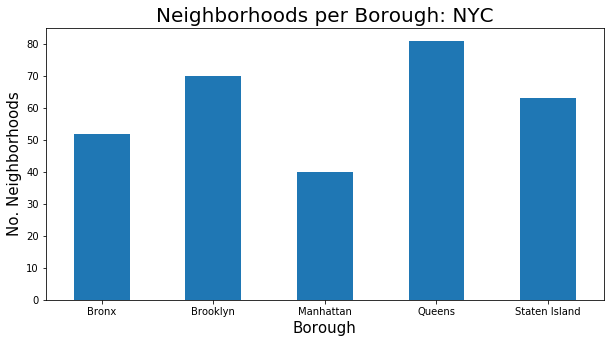

In [10]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5))
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [57]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    print(row)
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
chinese_rest_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv',index_col=0)
chinese_rest_ny.tail()


,Borough,Neighborhood,ID,Name
171,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
172,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
173,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
174,Bronx,Kingsbridge Heights,4e4d03acbd413c4cc66dfed6,New No. 1 Chinese Restaurnt
175,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


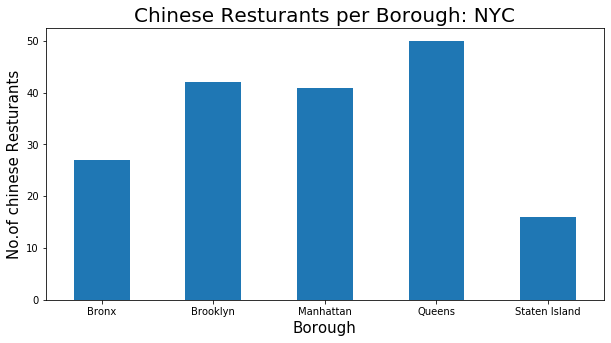

In [58]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Chinese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

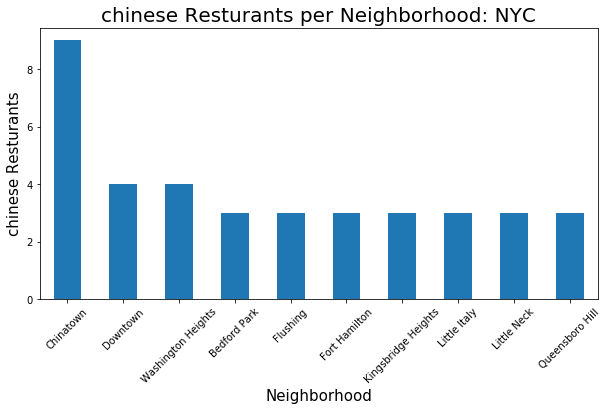

In [59]:
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot.bar(figsize=(10,5))
plt.title('chinese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('chinese Resturants', fontsize=15)
plt.xticks(rotation = 45)
plt.show()

In [60]:
chinese_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
1,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
2,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant
...,...,...,...,...
171,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
172,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
173,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
174,Bronx,Kingsbridge Heights,4e4d03acbd413c4cc66dfed6,New No. 1 Chinese Restaurnt


In [64]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv') 

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ecb729ce6a001bb06f76'}, 'response': {}}
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 1 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee390cc1fd001b7da461'}, 'response': {}}
No data available for id= 4dabc3dc93a04642f09ccabd
( 2 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2eee447b43d0023cded99'}, 'response': {}}
No data available for id= 4e41d2c4b61ca5ba3b1f9c6b
( 3 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ef97df2774001bca8eaa'}, 'response': {}}
No data available for id= 4b9d6b45f964a52078ab36e3
( 4 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee81c546f3001b2542b3'},

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2eda2b4b684001babb4e7'}, 'response': {}}
No data available for id= 4c5075d73940be9ae2124a07
( 39 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee52d03993001b0bdfc2'}, 'response': {}}
No data available for id= 4a71ff01f964a52016da1fe3
( 40 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2eeb89da7ee001bed6a84'}, 'response': {}}
No data available for id= 521bf3b711d2dce4f1b42195
( 41 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2efa0df2774001bcaa30b'}, 'response': {}}
No data available for id= 59da9590e1f0aa52976b8f35
( 42 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee2c1835dd001b36b81

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2eec1949393001cb18afa'}, 'response': {}}
No data available for id= 4aed1141f964a52001cd21e3
( 77 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee8283525f001b508942'}, 'response': {}}
No data available for id= 5e024619523cd2000769f67a
( 78 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee490cc1fd001b7dcbff'}, 'response': {}}
No data available for id= 4e3484038877beb5e9a22a0b
( 79 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2eda3882fc7001b326d8a'}, 'response': {}}
No data available for id= 44e9b421f964a520a5371fe3
( 80 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2eeca0be7b4001b5b7c3

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee98c546f3001b257a04'}, 'response': {}}
No data available for id= 4bc25d5b4cdfc9b627109621
( 115 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ed0e40a7ea001b8dc66c'}, 'response': {}}
No data available for id= 571ab7b2498ed52e0d5f4bca
( 116 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2efaedf2774001bcac72c'}, 'response': {}}
No data available for id= 4bd4debc4e32d13a9419c080
( 117 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ee6369babe001beca4cb'}, 'response': {}}
No data available for id= 4df56327c65bf55ee53269c2
( 118 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2efaedf2774001bc

( 153 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ed1640a7ea001b8dd8a8'}, 'response': {}}
No data available for id= 5090507fe4b095c5d7dab120
( 154 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2efb5df2774001bcad998'}, 'response': {}}
No data available for id= 4e4ce4a1bd413c4cc66d03da
( 155 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2edd5a2e538001b2f86f6'}, 'response': {}}
No data available for id= 514f8b4be4b01f10c950f1c7
( 156 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5ed2ed26bae9a2001b26fbd9'}, 'response': {}}
No data available for id= 4ce49482e571a09332bc8587
( 157 / 176 ) processed
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestI

In [76]:
chinese_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,0,0,0.0,0,0.0
1,Bronx,Eastchester,0,0,0.0,0,0.0
2,Bronx,Norwood,0,0,0.0,0,0.0
3,Bronx,Pelham Parkway,0,0,0.0,0,0.0
4,Bronx,Bedford Park,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...
171,Bronx,Allerton,0,0,0.0,0,0.0
172,Bronx,Kingsbridge Heights,0,0,0.0,0,0.0
173,Bronx,Kingsbridge Heights,0,0,0.0,0,0.0
174,Bronx,Kingsbridge Heights,0,0,0.0,0,0.0


In [65]:
chinese_rest_stats_ny.shape

(176, 7)

In [66]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
Borough         176 non-null object
Neighborhood    176 non-null object
ID              176 non-null object
Name            176 non-null object
Likes           176 non-null object
Rating          176 non-null object
Tips            176 non-null object
dtypes: object(7)
memory usage: 9.8+ KB


In [67]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
Borough         176 non-null object
Neighborhood    176 non-null object
ID              176 non-null object
Name            176 non-null object
Likes           176 non-null float64
Rating          176 non-null object
Tips            176 non-null float64
dtypes: float64(2), object(5)
memory usage: 9.8+ KB


In [68]:
chinese_rest_stats_ny.describe()

,Likes,Tips
count,176.0,176.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [69]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough              Bronx
Neighborhood    Co-op City
ID                       0
Name                     0
Likes                    0
Rating                   0
Tips                     0
Name: 0, dtype: object

In [83]:
chinese_rest_stats_ny['Rating'] = chinese_rest_stats_ny['Rating'].astype(float)
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough              Bronx
Neighborhood    Co-op City
ID                       0
Name                     0
Likes                    0
Rating                   0
Tips                     0
Name: 0, dtype: object

In [84]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough              Bronx
Neighborhood    Co-op City
ID                       0
Name                     0
Likes                    0
Rating                   0
Tips                     0
Name: 0, dtype: object

In [85]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Allerton,0.0
73,North Riverdale,0.0
85,Queens Village,0.0
84,Prince's Bay,0.0
83,Pelham Parkway,0.0
82,Pelham Gardens,0.0
81,Pelham Bay,0.0
80,Parkchester,0.0
79,Park Slope,0.0
78,Ozone Park,0.0


In [86]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
0,Bronx,0.0
1,Brooklyn,0.0
2,Manhattan,0.0
3,Queens,0.0
4,Staten Island,0.0


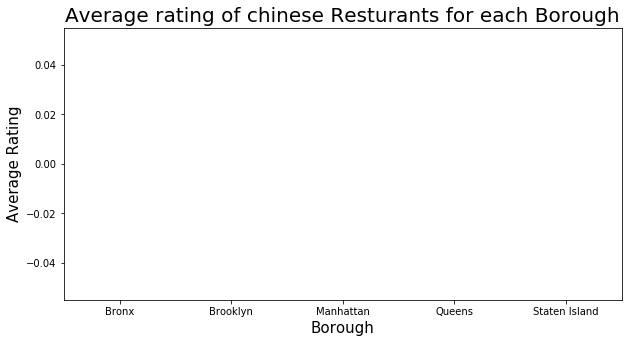

In [88]:
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('Average rating of chinese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()


In [89]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating


In [90]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats


,Borough,Neighborhood,Latitude,Longitude,Average Rating


In [93]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')


In [95]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')
